## Welcome to the first-ever (and hopefully last-ever) remote ADA final exam (Fall 2020)

In this exam, you will analyze data from Wikipedia and from the [Wikispeedia](https://dlab.epfl.ch/wikispeedia/play/) game, which you have already encountered in lecture 12 on [“Handling networks”](https://docs.google.com/presentation/d/1h6cIINJ9cNZ-Rtb7SskXrl9Xet5zPUoX2oJlNM0loHQ/edit#slide=id.g464f30ace1_0_92). The rules of the Wikispeedia game are simple:
1. Players are given two Wikipedia articles: a *source* and a *target*.
2. Starting from the source article, the goal is to reach the target, exclusively by following links in the articles encountered along the path.

### The data

The Wikispeedia data comprises ~76K games by human players, thereby capturing human navigation behavior on a very small subset of English Wikipedia comprising ~4.5K articles with a total of ~120K links between them.

The dataset is available in the `data` directory pushed to the same GitHub repo as the exam. Inside the data directory, you will find four files:

####  1. `article_df_task-A.tsv.gz`: A tab-separated file with the following information about Wikipedia articles
- *name*: The name of the Wikipedia article
- *topic*: The top-level topic label for the article (each article is assigned exactly one topic label)
- *content*: The cleaned text of the article (having removed punctuations, stopwords, numbers, and letter casing). It is stored as a space-separated string.

#### 2. `links_task-B.tsv.gz`: A tab-separated file containing Wikipedia links
- *linkSource*: The name of the source Wikipedia article from which the link originates
- *linkTarget*: The name of the target Wikipedia article to which the link points

#### 3.  `paths_df_task-B.tsv.gz`: A tab-separated file with the following information about the played games
- *hashed_ip_address*: Anonymized IP address of the player
- *source*: The name of the Wikipedia article from where the game started
- *target*: The name of the target article that the player was supposed to reach 
- *finished*: Whether the game was successfully finished (whether the player reached the target article)
- *human_path_length*: The number of clicks made by the player, before they either reached the target (in *finished* games) or gave up (in *unfinished* games)
- *shortest_path_length*: The minimum number of clicks required to reach the target article from the source article. Disconnected source-target article pairs have a shortest_path_length of *-1*.
- *duration_in_sec*: The duration of the game in seconds

#### 4.  `paths_df_task-C.tsv.gz`: In continuation to the task-B paths dataframe, this tab-separated file has the following additional information
- *in_degree_target*: In-degree of the target article, that is the number of incoming links that lead to the target article

*Note: In all the aforementioned files, the first line contains the header information. Additionally, article names are URL-encoded. For example, 'Antonín_Dvořák' is stored as 'Anton%C3%ADn_Dvo%C5%99%C3%A1k'. If needed, you can decode the article names using this code: `from urllib.parse import unquote; unquote('article-name')`.*

In [1]:
''' Some minimalistic imports '''
import random
import gzip
import operator
import time
from urllib.parse import unquote

# General packages
import pandas as pd
import numpy as np
from collections import Counter

# ML
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, SCORERS, mean_squared_error, f1_score, plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV

# Stats
from statsmodels.stats import diagnostic, weightstats, proportion
import statsmodels.formula.api as smf
from scipy import stats

# Display figures
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from IPython.display import Image

# Networks 
import networkx as nx

# PySpark
import pyspark
import pyspark.sql
from pyspark.sql import *
from pyspark.sql.functions import *

# NLP
import spacy
import vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
from gensim.models.phrases import Phrases
from gensim.corpora import Dictionary
from gensim.models import LdaMulticore
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

#  Create color generator (20 colors)
from itertools import cycle
colors = cycle([plt.get_cmap('tab20')(i/20) for i in range(20)])

In [2]:
default_color = next(colors)

# Task A. Can we predict article topic using textual content? (30 points)

*Note-1: For the entire Task A, we will use logistic regression for its scalability and simplicity. Specifically, we will use [SGDClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html) available in `sklearn` with 'log' loss and '5' epochs for training a logistic regression classifier.*

*Note-2: In all the cases where random number generation is required (train-test split, fitting the model, etc.), make sure to use 42 as the random seed.*

### A1. Load the text data and analyze the topic distribution (2 points)
1. Load `data/article_df_task-A.tsv.gz` as a pandas dataframe.   
   *Note: we have already cleaned the text for you!*
2. Print the total number of unique topics. Additionally, using a plot of appropriate type, analyze the article topic distribution.   
   **/Discuss:/** What do you observe? Are different topics equally likely? If not, is there a large disparity between certain highly popular and very rare topics?

### 1)

In [3]:
data_dir = './data/'
articles_A_raw = pd.read_csv(data_dir + 'article_df_task-A.tsv.gz', sep='\t')
articles_A = articles_A_raw.copy()

In [4]:
articles_A.name = articles_A_raw.name.apply(unquote)

### 2)

In [5]:
unique_topics = set(articles_A.topic)
print(f"There are {len(unique_topics)} unique topics in the dataframe and they are:\n {list(unique_topics)}.")

There are 14 unique topics in the dataframe and they are:
 ['Design_and_Technology', 'Geography', 'Mathematics', 'Language_and_literature', 'Everyday_life', 'Business_Studies', 'Religion', 'Music', 'People', 'Citizenship', 'Science', 'IT', 'Art', 'History'].


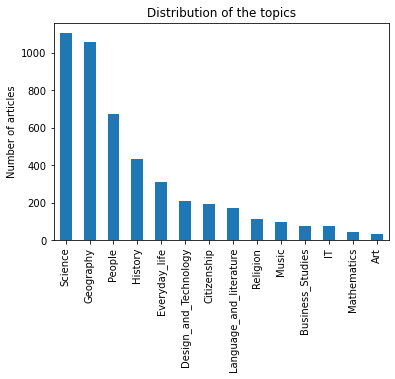

In [6]:
plt.figure()
articles_A.topic.value_counts().plot(kind='bar', color=default_color)
plt.ylabel('Number of articles')
plt.title('Distribution of the topics');

### Discussion:  
We observe that we topics are not equally distributed. However there is no very large disparity between the topics, the distribution is not following a power law.

### A2. Topic classification (multi-class): Articles from 5 most frequent topics (8 points)

#### A2.1 Prepping the data for ML (3 points)
1. Restrict the data to articles corresponding to the top-5 topics based on topic frequency.
2. Construct a TF-IDF representation of textual content.
3. Classes are defined by the topic labels, which are given as *strings*. However, for training classifiers via `sklearn` the class labels need to be encoded as ordinals. Perform this encoding and add a new column of ordinal class labels in the current dataframe.
4. Create two numpy arrays: X (TF-IDF representation of each article) and y (class-label of each article).

#### A2.2 Train and evaluate a multi-class classifier (5 points)
1. Perform a train-test split with 70% as the training portion and the remainder as the testing portion. Use `random_state=42` for fixing the seed to 42.
2. Train a logistic regression classifier with L2 regularization using the `SGDClassifier()` method of `sklearn`. Use `SGDClassifier(loss='log', max_iter=5, tol=None, alpha=1e-4, random_state=42)` to initialize the classifier object. Do not modify the settings for any other parameter, let them be set to their default values.   
   **Important heads-up**: *Depending on the configuration of your computer, training the model could take up to 1 minute of compute time.*
3. Report the classifier performance on the test data using accuracy as the metric.
4. **/Discuss:/** Are you satisfied with the model performance? Qualitatively discuss the performance of the model by comparing it to a random baseline and justify your response.

**Important note:** *Based on the discussion in the class, logistic regression is a binary classification technique. A simple heuristic to perform multi-class classification using a binary classifier is to use the [one-vs.-rest (OVR)](https://en.wikipedia.org/wiki/Multiclass_classification#One-vs.-rest) strategy. In this strategy, a binary classifier is trained for each class with the capability to differentiate it from all the other classes, and thus, $k$ binary classifiers are trained for a $k$-class classification. Internally, `SGDClassifier()` uses the [OVR](https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html) strategy of `sklearn` whenever it sees the number of unique values in the **y** vector to be greater than 2. Thus, you can simply use it as a black-box! The only important point for this part is to make sure that the **y** vector of class-labels should have **5** unique values, one corresponding to each class-label.*

### A2.1)

In [7]:
# Extract top 5 topics
top5_topics = articles_A.topic.value_counts().nlargest(5).index.values
list(top5_topics)

['Science', 'Geography', 'People', 'History', 'Everyday_life']

In [8]:
# Keep only articles that are in the top 5
articles_A_top5 = articles_A[articles_A['topic'].isin(top5_topics)]
# Compute tfidf on the content of the articles
tfidf = TfidfVectorizer()
content_vectors = tfidf.fit_transform(articles_A_top5.content)

In [9]:
# Convert topics to categorical values (ordinal)
articles_A_top5['topic_id'] = articles_A_top5.topic.astype('category').cat.codes

In [10]:
X = content_vectors.toarray()
y = articles_A_top5.topic_id.values

### A2.2)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [12]:
sgd = SGDClassifier(loss='log', max_iter=5, tol=None, alpha=1e-4, random_state=42)
sgd.fit(X_train, y_train)

SGDClassifier(loss='log', max_iter=5, random_state=42, tol=None)

In [13]:
# Predict score (mean accuracy is used by default)
print(f"The accuracy using SGD classifier is : {sgd.score(X_test, y_test):.3f}")

The accuracy using SGD classifier is : 0.890


In [14]:
articles_A_top5.head(20)

,name,topic,content,topic_id
0,Áedán_mac_Gabráin,People,copyright aedan mac gabrain schools wikipedia ...,3
1,Åland,Geography,copyright aland schools wikipedia selection re...,1
2,Édouard_Manet,People,copyright edouard manet schools wikipedia sele...,3
3,Éire,Geography,copyright eire schools wikipedia selection rel...,1
4,Óengus_I_of_the_Picts,People,copyright oengus picts schools wikipedia selec...,3
6,10th_century,History,copyright 10th century schools wikipedia selec...,2
7,11th_century,History,copyright 11th century schools wikipedia selec...,2
8,12th_century,History,copyright 12th century schools wikipedia selec...,2
9,13th_century,History,copyright 13th century schools wikipedia selec...,2
10,14th_century,History,copyright 14th century schools wikipedia selec...,2


### Discussion:  
Since the accuracy found is 89%, the results are very convicing. Indeed, by random prediction, the accuracy would be around 20% (with 5 labels to predict) if the labels are equally distributed. In our case, the labels are not equally distributed and we should process the data as such as the data are equally distributed to make sure that the accuracy is due to a good prediction and not the ability to predict only the most common labels.  
Another alternative would be to use another metric such as F1 score to assess the results.

### A3. Topic classification (binary): Articles from the most and least frequent topics (12 points)

#### A3.1 Train and evaluate a binary classifier (2 points)
1. Restrict the data to articles belonging to the most frequent or to the least frequent topic.
2. Create two numpy arrays: X (TF-IDF representation of each article) and y (class-label of each article).
3. Perform a train-test split with 70% as the training portion and the remainder as the testing portion. Use `random_state=42` for fixing the seed to 42.
4. Train a logistic regression classifier with L2 regularization using the `SGDClassifier()` method of `sklearn`. Use `SGDClassifier(loss='log', max_iter=5, tol=None, alpha=1e-4, random_state=42)` to initialize the classifier object. Do not modify the settings for any other parameter, let them be set to their default values.
5. Report the classifier performance on the test data using accuracy as the metric.

In [15]:
# Extract most least frequent topics
most_frequent = articles_A.topic.value_counts().nlargest(1).index.values[0]
least_frequent  = articles_A.topic.value_counts().nsmallest(1).index.values[0]
most_least_frequent_topics = [most_frequent, least_frequent]
articles_A_most_least = articles_A[articles_A['topic'].isin(most_least_frequent_topics)]
# Compute TFIDF
content_vectors_most_least = tfidf.fit_transform(articles_A_most_least.content)
# Convert topics to categorical values (ordinal)
articles_A_most_least['topic_id'] = articles_A_most_least.topic.astype('category').cat.codes

# Compute features and labels
X_ml = content_vectors_most_least.toarray()
y_ml = articles_A_most_least.topic_id.values

# Separate train and test data
X_train_ml, X_test_ml, y_train_ml, y_test_ml = train_test_split(X_ml, y_ml, test_size=0.30, random_state=42)

# Train model 
sgd_ml = SGDClassifier(loss='log', max_iter=5, tol=None, alpha=1e-4, random_state=42)
sgd_ml.fit(X_train_ml, y_train_ml)

SGDClassifier(loss='log', max_iter=5, random_state=42, tol=None)

In [16]:
# Predict score (mean accuracy is used by default)
print(f"The accuracy using SGD classifier is : {sgd_ml.score(X_test_ml, y_test_ml):.3f}")

The accuracy using SGD classifier is : 0.968


#### A3.2 Assessing the evaluation metric (5 points)
1. **/Discuss:/** What is your take on the accuracy obtained in A3.1? Do you think accuracy is the correct evaluation metric for this task? If yes, justify! If not, why not, and what else can be used?
2. If you included additional evaluation metrics in A3.2.1, then perform an empirical analysis of the performance using these metrics.   
   **/Discuss:/** Additionally, discuss what you observe. Is it harder to predict the topic labels of certain articles? Why, or why not? Please elaborate!

### Discussion
1. Accuracy is not a good metric for unbalanced data. Indeed, most of the data are in one class and a very small part of the data are from another class. Thus, the model can just learn to predict only one label and if would make the accuracy very high even if it is never predict the under-represented class. We should use F1 to see how the model is able to predict all labels.


In [17]:
y_pred = sgd_ml.predict(X_test_ml)
f1_s = f1_score(y_test_ml, y_pred)
print(f"The F1 score using SGD classifier is : {f1_s:.3f}")

The F1 score using SGD classifier is : 0.984


### Discussion
2. We observe that the F1_score is still very high (i.e. 0.984). Thus, the prediction is accurate for both metrics and the results can be considered as good.
It can be difficult to predict topic labels because there are a lot of things that are similar between articles, it can be due to the scrapping of the data. Indeed, a lot of articles end with `> retrieved reference article mainly selected english wikipedia minor checks changes details authors sources available gnu free documentation license disclaimer`. It makes the classification even harder since a lot of part in the articles are similar since it has been scrapped from the webpage.

#### A3.3 Class proportions (5 points)
1. **/Discuss:/** Does the disparity in class proportions hurt the model? If yes, how can you fix it? If not, why not? Justify your response with clear and crisp reasons!    
   *Hint: The learning objective of a classifier can be modified by altering the importance of each class in the computation of the loss function.*
2. If your answer to the aforementioned question is a "yes", please do the following. If not, move to **Task A4**.
    * Implement the fix you proposed in A3.3.1, and repeat the classification task performed in Step A3.1 using the fixed model.
    * Vary the regularization parameter `alpha` in the range [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1], and using accuracy as the metric find and report its optimal value using 5-fold cross validation on the training set.   
       **Important heads-up**: *Depending on the configuration of your computer, grid search for the optimal value of `alpha` could take up to 1 minute of compute time.*
    * Lastly, using the optimal `alpha` identified in the previous step, redo the evaluations proposed in A3.2.   
       **/Discuss:/** Do you observe any differences from the results obtained in A3.2? Why, or why not? Please elaborate!

### Discussion:
Yes we can fix this by removing data from the over-represented label, but that would reduce the number of samples and therefore, the capacity of the model to predict the labels. Instead, we could make the underrepresented class much more important by applying weight, thanks to this, an error in the under-represented class would cost a lot and therefore the model will try to predict both class with the same importance.

In [18]:
representation = articles_A_most_least.topic.value_counts()
class_weight = {1:1, 0:representation[most_frequent]/representation[least_frequent]}
# Train model with class weight 
sgd_ml = SGDClassifier(loss='log', max_iter=5, tol=None, alpha=1e-4, random_state=42, class_weight=class_weight)
sgd_ml.fit(X_train_ml, y_train_ml)
y_pred = sgd_ml.predict(X_test_ml)
f1_s = f1_score(y_test_ml, y_pred)
print(f"The F1 score using SGD classifier is : {f1_s:.3f}")

The F1 score using SGD classifier is : 0.994


### Discussion: 
We observe a better accuracy. It was expected since now the model is most probably better at predicting the under-represented class, which was not really the case before.

### A4. Revisiting Multi-class classifier of A2.2 (4 points)

1. Print and analyze the confusion matrix for the multi-class model trained in A2.2. **/Discuss:/** What do you observe? Please elaborate!
2. **/Discuss:/** Similar to A3.3, does the disparity in class proportions hurt the model? If yes, how can you fix it? If not, why not? Justify your response with clear and crisp reasons!
3. If your answer to the aforementioned question is a "yes", please do the following. If not, move to **Task A5**.
    * Implement the fix you proposed in A4.2, and repeat the classification task performed in Step A2.2 using the fixed model.
    * Vary the regularization parameter `alpha` in the range [1e-6, 1e-5, 1e-4, 1e-3], and using accuracy as the metric find and report its optimal value using 5-fold cross validation on the training set.   
       **Important heads-up**: *Depending on the configuration of your computer, grid search for the optimal value of `alpha` could take up to 2 minutes of compute time.*
    * Lastly, using the optimal `alpha` identified in the previous step, obtain the accuracy and confusion matrix.
4. **/Discuss:/** Contrast the confusion matrix obtained in A4.1 with the one obtained in A4.3. Do you observe any differences? Why, or why not? Please elaborate!

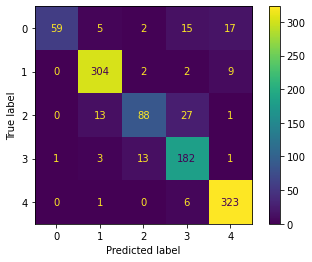

In [19]:
plot_confusion_matrix(sgd, X_test, y_test)

### Discussion
We observe that generally, the diagonal is very bright (high values) when the other values are a lot lower. This is a sigh that the model is really well performing on the dataset.
Therefore, the model doesn't seem to be hurt by the unbalanced labels in the data.

### A5. Interpretability (4 points)
1. For each of the 5-classes considered in **A4**, obtain a list of top-10 words (sorted in descending order of their importance) based on the feature weights learned by the classifier.

2. **/Discuss:/** Qualitatively discuss the relevance of the identified words and their association with the respective class-labels. Is the classifier correct to assign them high weights? Are they truly discriminative/predictive of the respective class-labels? Justify your responses with clear and crisp reasons!

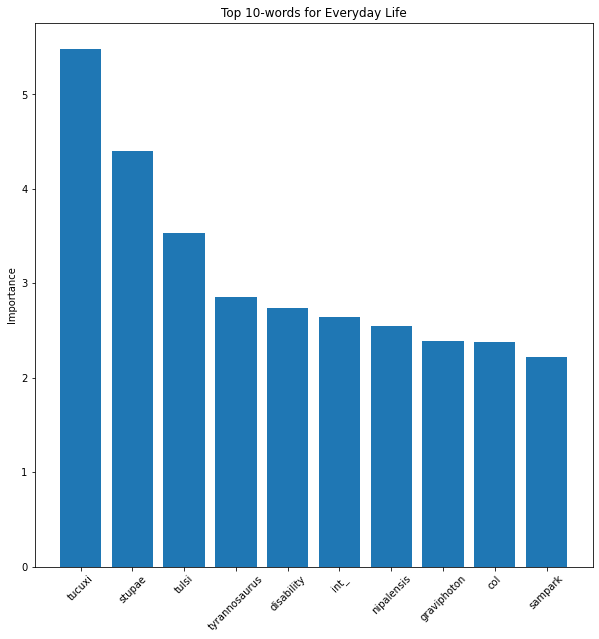

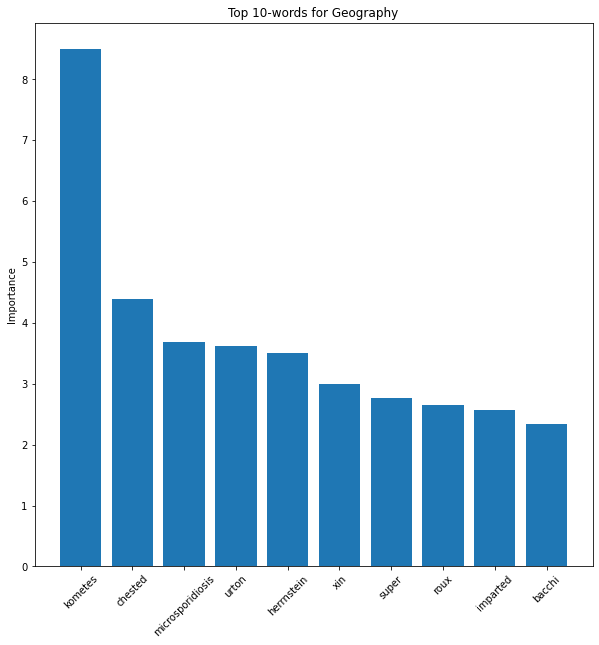

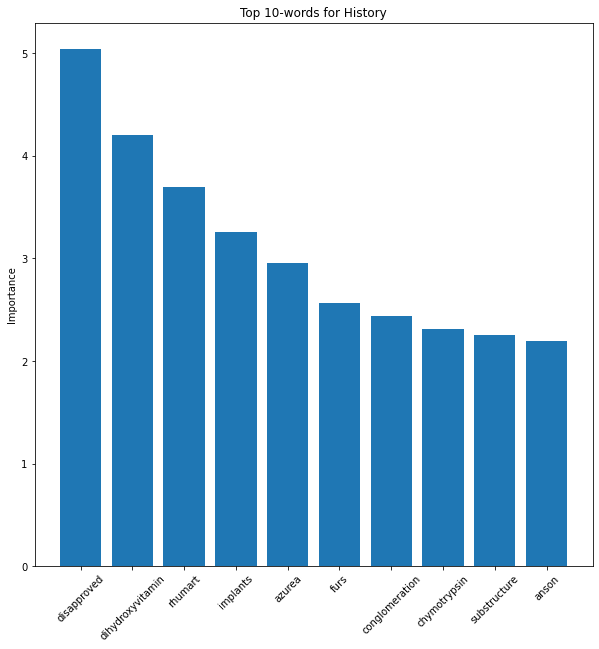

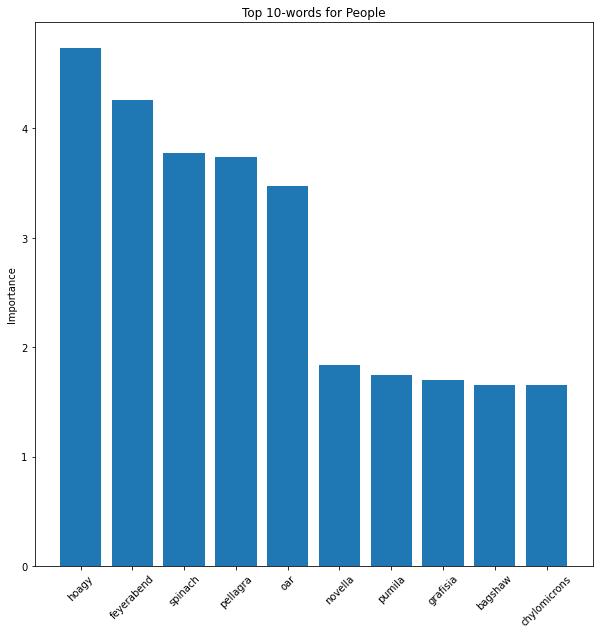

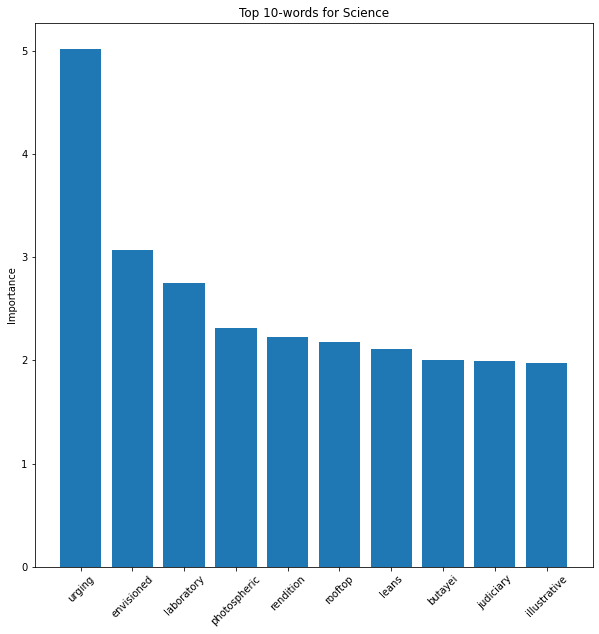

In [20]:
dictionary_topic = {0:'Everyday Life',1:'Geography',2:'History',3:'People',4:'Science'}
for i in range(5):
    tmp = []
    for name, value in zip(tfidf.get_feature_names(), sgd.coef_[i]):
        tmp.append({"name": name, "value": value})
    
    #sort them all by coefficients
    features_coef = pd.DataFrame(tmp).sort_values("value", ascending=False).set_index('name')
    # Plot coefficients
    plt.subplots(figsize=(10,10))
    plt.bar(features_coef.index[:10], features_coef.value[:10])
    plt.xticks(rotation=45)
    plt.ylabel('Importance')
    plt.title(f'Top 10-words for {dictionary_topic[i]}')

# Task B. The Wikipedia link network (30 points)

### B1. Wikipedia network: reveal your shape! (12 points)
#### B1.1 Load the Wikipedia link network (`data/links_task-B.tsv.gz`) into memory as a directed graph using `NetworkX`. (4 points)
1. Compute the following from the loaded graph object:
    * the number of nodes,
    * the number of edges, and
    * the average degree.
2. **/Discuss:/** In order to summarize the degree distribution in a single number, would you recommend using the average degree? Why, or why not? If not, what alternatives can you think of? Please elaborate!

In [21]:
links_B_raw = pd.read_csv(data_dir + 'links_task-B.tsv.gz', sep='\t')
links_B_raw.linkSource = links_B_raw.linkSource.apply(unquote)
links_B_raw.linkTarget = links_B_raw.linkTarget.apply(unquote)
graph = nx.from_pandas_edgelist(links_B_raw, 'linkSource', 'linkTarget' ,create_using=nx.DiGraph())

In [22]:
nb_nodes = graph.number_of_nodes()
nb_edges = graph.number_of_edges()
avg_degree = 2*nb_edges/nb_nodes
print(f"The graph has {nb_nodes} nodes, {nb_edges} edges and an average degree of {avg_degree:.2f} (average in degree : {avg_degree/2:.2f} and average out degree : {avg_degree/2:.2f})")

The graph has 4592 nodes, 119882 edges and an average degree of 52.21 (average in degree : 26.11 and average out degree : 26.11)


### Discussion:
TODO

#### B1.2 Using the appropriate plot type, plot the in-degree and out-degree distributions of the Wikipedia link network and analyze it. (4 points)
1. **/Discuss:/** What is the appropriate scale of the axes?
2. **/Discuss:/** Does the distribution (roughly) follow a particular distribution, and if yes, which one? Additionally, explain how you arrived at your conclusion.

In [23]:
def plot_degree_hist(G, out=False):
    if out:
        degrees = [G.out_degree(n) for n in G.nodes()]
    else:
        degrees = [G.in_degree(n) for n in G.nodes()]
    plt.figure(figsize=(5,5))
    array = plt.hist(degrees, bins=100, color=default_color, log=True)
    plt.loglog(array[1][1:],array[0])

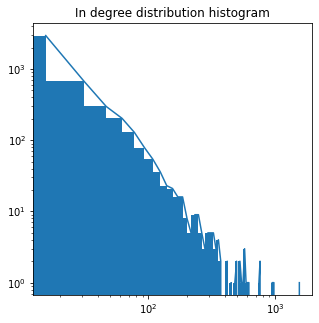

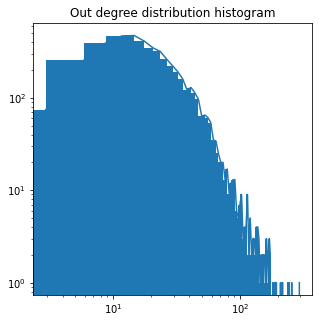

In [24]:
plot_degree_hist(graph)
plt.title('In degree distribution histogram')
plt.show()
plot_degree_hist(graph, out=True)
plt.title('Out degree distribution histogram')
plt.show()

### Discussion:
The appropriate scale of the axes are log-log plots as it seems to follow a power law since there are some nodes that very high degree while most of the nodes have a very low degrees.

#### B1.3 Connectedness of the Wikipedia link network (4 points)

**Definition-1:** An undirected graph $G$ is said to be connected if, for every pair of vertices $(u, v)$, it contains a path that connects the two vertices.

**Definition-2:** A directed graph $G_{dir}$ is **weakly connected** (or simply connected) if the underlying undirected graph obtained by replacing all directed edges of the graph with undirected edges is a connected graph (cf. Definition-1). 

**Definition-3:** A directed graph $G_{dir}$ is **strongly connected** if, for every pair of vertices $(u, v)$, it contains a directed path from $u$ to $v$ and a directed path from $v$ to $u$.

Given these definitions, what can you say about the connectedness of the Wikipedia link network? Specifically, answer the following:  
1. Is the Wikipedia link network weakly connected? If not, print the number of weakly connected components. Additionally, print the number of nodes and edges of the subgraph corresponding to the largest weakly connected component.  
2. Is the Wikipedia link network strongly connected? If not, print the number of strongly connected components. Additionally, print the number of nodes and edges of the subgraph corresponding to the largest strongly connected component.

In [25]:
if nx.is_connected(graph.to_undirected()):
    print('The undirected graph is connected!')
else:
    print('The undirected graph is not connected!')

if nx.is_strongly_connected(graph):
    print('The graph is strongly connected!')
else:
    print(f'The graph is not strongly connected, the number of strongly connected components is {nx.algorithms.components.number_strongly_connected_components(graph)}.')
    sub_graph = graph.subgraph(list(nx.strongly_connected_components(graph))[1])
    print(f"Largest strongly connected component has {sub_graph.number_of_nodes()} nodes and {sub_graph.number_of_edges()} edges")

if nx.is_weakly_connected(graph):
    print('The graph is weakly connected!')
else:
    print(f'The graph is not weakly connected, the number of weakly connected components is {nx.algorithms.components.number_weakly_connected_components(graph)}.')
    sub_graph = graph.subgraph(list(nx.weakly_connected_components(graph))[1])
    print(f"Largest weakly connected component has {sub_graph.number_of_nodes()} nodes and {sub_graph.number_of_edges()} edges")
# Don't know how to create subgraph from components....

The undirected graph is not connected!
The graph is not strongly connected, the number of strongly connected components is 519.
Largest strongly connected component has 1 nodes and 0 edges
The graph is not weakly connected, the number of weakly connected components is 2.
Largest weakly connected component has 3 nodes and 3 edges


### B2. The interplay between human navigation behavior and Wikipedia network structure (18 points)

#### B2.1 Loading and analyzing the game data (3 points)
1. Load `data/paths_df_task-B.tsv.gz` as a pandas dataframe.
2. Some games were successfully finished (*finished=True*) while others were unsuccessful (i.e., the player gave up before reaching the target article). However, not all unsuccessful games are infeasible; the player might simply not have been good enough at the game to reach the target from the source. **/Discuss:/** Clearly state the reasons why there may be games that are *truly infeasible*.   
3. List all unsuccessful games that are *truly infeasible* and remove them from the dataframe.

In [26]:
paths_B = pd.read_csv(data_dir + 'paths_df_task-B.tsv.gz', sep='\t')

### Discussion:
Since the graph is not connected it might be possible that there is not path between two nodes, and thus, the game is tru infeasible.

In [27]:
unfeasible_games = paths_B[paths_B['finished']==False]
unfeasible_games = paths_B[paths_B['shortest_path_length'] == -1]
print(unfeasible_games)
path_length = len(paths_B)
paths_B.drop(index=unfeasible_games.index, inplace=True)
print(f'We removed {path_length-len(paths_B)} unfeasible games.')

      hashed_ip_address             source                          target  \
53533  4c03b8fb18fc9752   Oasis_%28band%29  Final_Fantasy_%28video_game%29   
56880  3af13b307343dec9       Adolf_Hitler                       The_Frogs   
63647  093e40d06992b8dc         Anne_Frank  Final_Fantasy_%28video_game%29   
63648  093e42416992ba4d         Anne_Frank  Final_Fantasy_%28video_game%29   
64511  17ef27577d43939d                Toy                            Lego   
66654  5e55877267bd6864        Hymenoptera      Portuguese_Communist_Party   
71566  3d9b105c56bcf38a   Private_Peaceful                            Unix   
75567  360d256e3fd2a746  Quantum_mechanics                        Blue_Tit   

       finished  human_path_length  shortest_path_length  duration_in_sec  
53533     False                  1                    -1               13  
56880     False                  6                    -1             1874  
63647     False                 21                    -1             

#### B2.2 Wikispeedia => Wikislowia? (9 points)
1. Compute and report the average and median path lengths for games that were successfully finished (*finished=True*). You should compute and report path length in two ways: (1) with respect to the number of clicks needed by *human players*, (2) with respect to the *minimum* number clicks an *optimal player* would need.   
   **/Discuss:/** What can you say about the navigability of the Wikipedia link network?   
   *Hint: Think about [Milgram's experiment](https://docs.google.com/presentation/d/1h6cIINJ9cNZ-Rtb7SskXrl9Xet5zPUoX2oJlNM0loHQ/edit#slide=id.g464f30ace1_0_261) and relate your findings with his findings!*
2. **/Discuss:/** Suppose you want to maliciously decrease Wikipedia's navigability. You are allowed to remove certain edges in the network. What criterion would you use to decide which edges should be removed? Additionally, discuss why these edges are critical for Wikipedia's navigability. Justify your answer with clear and substantive reasoning!   
   _Hint: Navigability of a network depends on the existence of short paths in the network._
3. **/Discuss:/** In continuation to B2.2.2, assume you are given a budget of $k<<n$ edges to be removed. Design the algorithm that you would employ, provide its pseudocode (as a list of steps), and justify your algorithm design choice.   
   *Note: You don't have to describe the steps for computing the criterion you identified in Step B.2.2. Instead, using the identified criterion as a blackbox, you have to provide the steps required to remove $k>1$ edges.*

In [28]:
finished_games = paths_B[paths_B['finished']==True]
finished_games.describe().loc[['mean', '50%']][['human_path_length', 'shortest_path_length']]

,human_path_length,shortest_path_length
mean,6.757493,2.8455
50%,6.000000,3.0000


The mean and median are reported on the previous table.  

### Discussion:

1. It seems that human take generally two times more clicks than the minimum needed. It is very interesting, it could have been a lot more but since human have a notion of *what topics could lead to the goal I'm trying to reach*, the results are very good given that human don't have any idea of the graph that link articles structure.

2. To reduce the navigability, we could remove edges that have the most centrality (could be closeness centrality, Katz centrality, PageRank centrality, etc). Using this would make the average short path longer since these nodes where very central and thus, allowed to connect many nodes.

3. Algorithm:
> 1. For i in 1...k
>> 1. Compute closeness centrality for every nodes
>> 2. Take node with maximum centrality
>> 3. Find neighbour node with highest centrality
>> 4. Remove edge between two nodes

#### B2.3 Relationship between network structure and game completion (6 points)
1. Enrich the dataframe with the eigenvector centrality and in-degree of the target article for each game path.
2. Using plots of appropriate type, plot the in-degree distribution of the target articles of game paths. What is the appropriate scale of the axes? Additionally, summarize the in-degree distribution of the target articles in a single number using a suitable metric. Justify your choice of the metric.
3. Using plots of appropriate type, analyze the differences in in-degree and eigenvector centrality of finished and unfinished games.   
   **/Discuss:/** What do you observe? Clearly discuss your observations!

In [29]:
'''your answer/code here''';

# Task C. Putting on the causality hat (30 points)

### C1. Are articles with high in-degree easier to find? A naive analysis (6 points)

Recall that in each Wikispeedia game, a player is **randomly** assigned a source article and a target article. In task **C**, we are interested in measuring the effect of the target article's in-degree on the player's chances of successfully finishing the game.

1. Load `data/paths_df_task-C.tsv.gz` as a pandas dataframe.
2. Consider target articles with fewer than 20 incoming links to have a *low in-degree* and articles with at least 20 to have a *high in-degree*.
3. Calculate the fraction of games with a high-in-degree target that was finished, and the fraction of games with a low-in-degree target that was finished. Do you observe significant differences, and in what direction? (You may do a statistical test or provide confidence intervals.)
4. Repeat the same analysis for the game duration, for finished games only.
5. Quantify and discuss your findings from Steps C1.3 and C1.4.

In [30]:
paths_C = pd.read_csv(data_dir + 'paths_df_task-C.tsv.gz', sep='\t')
paths_C['high_in_degree'] = paths_C.in_degree_target >= 20

In [31]:
paths_C.head()

,hashed_ip_address,source,target,finished,human_path_length,shortest_path_length,duration_in_sec,in_degree_target,high_in_degree
0,6a3701d319fc3754,14th_century,African_slave_trade,True,9,3,166,7.0,False
1,3824310e536af032,14th_century,African_slave_trade,True,5,3,88,7.0,False
2,415612e93584d30e,14th_century,African_slave_trade,True,8,3,138,7.0,False
3,64dd5cd342e3780c,14th_century,Greece,True,4,2,37,246.0,True
4,015245d773376aab,14th_century,John_F._Kennedy,True,7,3,175,60.0,True


In [32]:
finished_low = paths_C.loc[paths_C['high_in_degree']==False]
finished_low_ratio = len(finished_low.loc[finished_low['finished']==True]) /len(finished_low)
finished_high = paths_C.loc[paths_C['high_in_degree']==True]
finished_high_ratio = len(finished_high.loc[finished_high['finished']==True]) /len(finished_high)
print(f'Ratio of finished games with low target in degree : {finished_low_ratio:.3f},\nRatio of finished games with high target in degree : {finished_high_ratio:.3f}')

stats.ttest_ind(finished_low.finished, finished_high.finished)

Ratio of finished games with low target in degree : 0.562,
Ratio of finished games with high target in degree : 0.778


Ttest_indResult(statistic=-65.30438592344109, pvalue=0.0)

Null hypothesis: the expectation of finishing the game are the same for high and low degree target.   
Given that we have fixed the significance threshold to 0.05 and that we get a p-value < 0.0001 we reject the null hypothesis (as pvalue < significance threshold) that the two expectations are equals. Thus, it is most probable (and it is significently different) to win a game when the target has a high in degree than when it has a low in  degree

In [33]:
finished = paths_C.loc[paths_C['finished']==True]
finished_high = finished.loc[finished['high_in_degree']==True]
finished_low = finished.loc[finished['high_in_degree']==False]
print(f'Duration of finished games with low target in degree : {finished_low.duration_in_sec.mean():.3f} s,\nRatio of finished games with high target in degree : {finished_high.duration_in_sec.mean():.3f} s')
stats.ttest_ind(finished_high.duration_in_sec, finished_low.duration_in_sec)

Duration of finished games with low target in degree : 199.572 s,
Ratio of finished games with high target in degree : 130.429 s


Ttest_indResult(statistic=-21.38300527091685, pvalue=5.3178885355993734e-101)

Null hypothesis: the mean of duration to finish the game are the same for high and low degree target.   
Given that we have fixed the significance threshold to 0.05 and that we get a p-value < 0.0001 we reject the null hypothesis (as pvalue < significance threshold) that the two expectations are equals. Thus, it is shorter in time (and it is significently different) to win a game when the target has a high in degree than when it has a low in  degree.

### C2. Modeling the study setup with a causal diagram (9 points)

**C2.1** We are interested in the effect of target in-degree (**deg(T)**) on the binary outcome **(O)** that captures whether the game was successfully finished or not. In the previously conducted naive analysis, we did not take into account the shortest path length **(L)**, which is the minimum number of clicks necessary in order to reach the target article from the source article **(S)**. Target and source articles are randomly assigned, independently from each other. The assigned source article S and deg(T) affect the shortest path length L. The source article affects the outcome through the shortest path length, and also directly, as some sources might be more central in the network.   
Choose a causal diagram **(A, B, C, D, E, or F)** that corresponds to the described relationships between the following 4 variables. Additionally, justify your choice and explain your reasoning. **(4 points)**
- **deg(T):** target in-degree,
- **L:** shortest path length between source and target,
- **S:** name of source article,
- **O:** outcome, i.e., the binary indicator that says whether the game was successfully finished.

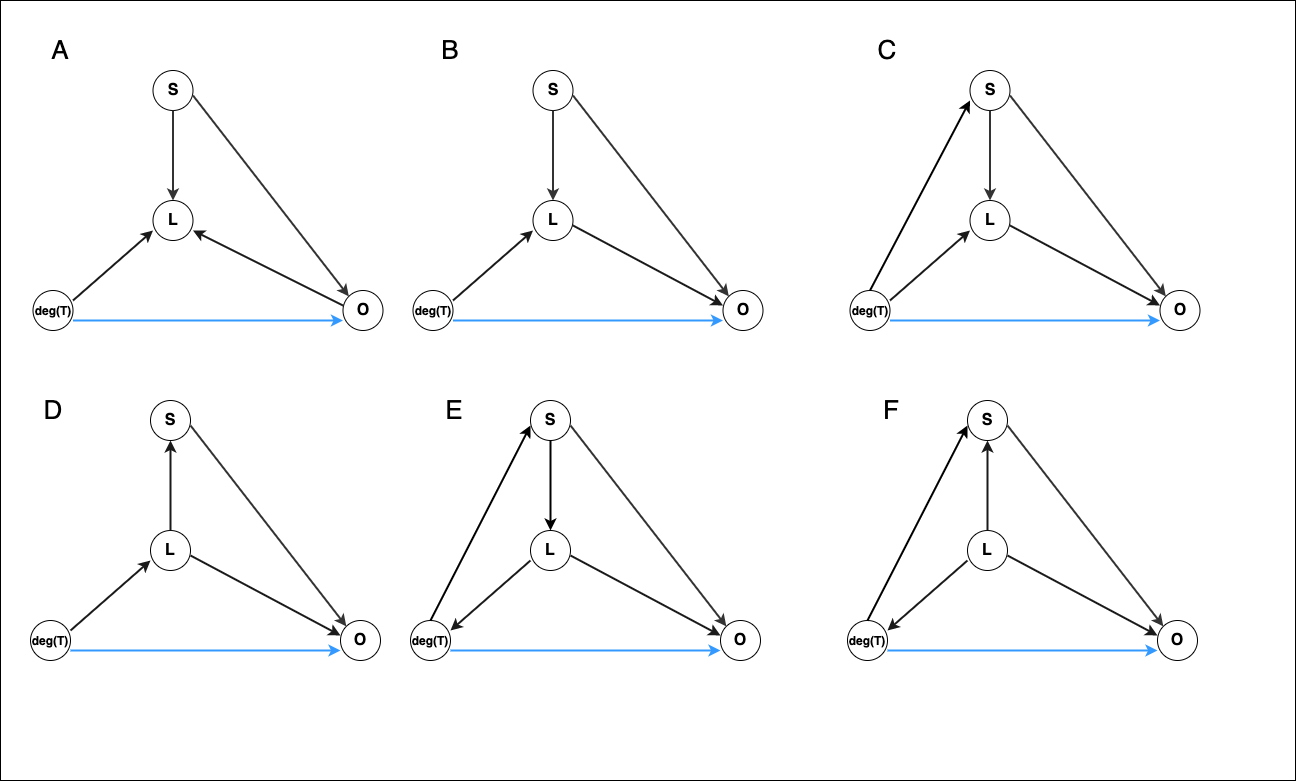

In [34]:
Image(filename="img/diagram.png") 

The good diagram is the diagram B.
Indeed, we previously saw that the in degree directly affect the shortest path length as well as the output.
The longer the shortest path the more difficult it is to solve the problem. Similarly, the choice of source article has a big importance on the output and as well as on the shortest path. The diagram that reflects this description is diagram B.

**C2.2** **/Discuss:/** What is potentially misleading about the naive analysis done in task **C1**? In what conceivable ways could the conclusions about the impact of target in-degree **deg(T)** on the outcome **O** be wrong?
Could the findings go in the opposite direction of a true direct causal effect? Justify your answer. **(5 points)**

In [35]:
'''your answer here''';

### C3. A more controlled analysis: matching on source article and shortest path length (15 points)

Let's now understand how the estimated effect of the target in-degree would differ if we controlled for both the source article and the shortest path length between source and target. Construct a set of matched pairs of games. In a matched pair, the two games differ in target in-degree (one has a high in-degree, and the other has a low in-degree), but the source article and the shortest path length are exactly the same. Note that your output must be a 1-to-1 matching.

1. Perform exact matching on source article and shortest path length. This means that two candidate games can be matched only if the source article and the shortest path length are exactly the same. Additionally, report the number of matched pairs of games. **(7 points)**   
   **Important heads-up**: *Depending on the configuration of your computer, computing the exact matching could take up to 3 minutes of compute time.*
2. Among the matched pairs of games, calculate the fraction of games with a high-in-degree target that was successfully finished, and the fraction of games with a low-in-degree target that was successfully finished. Do you observe significant differences, and in what direction? (You may do a statistical test or provide confidence intervals.) **(3 points)**
3. **/Discuss:/** What do you observe? Are the conclusions different from the conclusions reached in C1? If yes, speculate as to why that is the case. How is the estimation in task C1 different from the estimation in task C3? **(4 points)**
4. **/Discuss:/** Based on your findings, how should Wikipedia be modified in order to increase the fraction of finished Wikispeedia games? **(1 points)**

*Hint: How you construct the set of matched pairs is up to you. One way can be to build an unweighted bipartite graph where games with targets with a high in-degree are on one side (the "treated class"), and games with targets with a low in-degree are on the other side (the "control class"). The edge between two matching candidate games is created only if there is an exact match on the source article and the shortest path length. Based on this bipartite graph, you can then find the **optimal** matching. However, note that this is neither the required nor the only way.*

In [36]:
'''your answer/code here''';